In [1]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install torch-summary
!pip install graphviz
!pip install torchview
!pip install contractions
!pip install pyspellchecker

!mkdir ./checkpoints
!mkdir ./datasets

import sys, os

user = "HLT-Ghisolfi-Leuzzi-Testa"
repo = "WASSA-2023"
branch = "irene"

if os.path.isdir(repo):
  !rm -rf {repo}

!git clone -b {branch} https://github.com/{user}/{repo}

sys.path.insert(1, repo)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torchsummary import summary
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
from torch.optim import AdamW
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import json
from utils import EMODataset

In [3]:
TRAIN_DATA = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/datasets/WASSA23_essay_level_train_preproc.tsv"
VAL_DATA = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/datasets/WASSA23_essay_level_val_preproc.tsv"
DEV_DATA = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
OPT_STEP_SIZE = 1
OPT_GAMMA = 0.9
EPOCHS = 1
RANDOM_STATE = 42
MODEL_NAME = 'bert-base-cased'
NUM_LABELS = 8

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, truncation=True)

gold = [emotion.split('/') for emotion in train_df.emotion]
mlb = MultiLabelBinarizer()
mlb.fit(gold)
gold_train = [emotion.split('/') for emotion in train_df.emotion]
gold_val = [emotion.split('/') for emotion in val_df.emotion]
gold_test = [emotion.split('/') for emotion in dev_df.emotion]
y_train = mlb.transform(gold_train)
y_val = mlb.transform(gold_val)
y_dev = mlb.transform(gold_test)

############################ SUB-SAMPLE ############################
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

training_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

training_loader = DataLoader(
    training_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, # reshuffles at every epoch
    )
val_dataloader = DataLoader(
    val_set,
    batch_size=VALID_BATCH_SIZE,
    shuffle=True# reshuffles at every epoch
    )
dev_loader = DataLoader(
    dev_set,
    batch_size=1,
    shuffle=False # TODO: sure?
    )

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
num_training_steps = EPOCHS * len(training_loader)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# save model summary as txt and pdf

model_summary = str(summary(model, dtypes=['torch.IntTensor']))
text_summary_file = open(MODEL_NAME+"_summary.txt", "w")
text_summary_file.write(model_summary)
text_summary_file.close()

model_graph = draw_graph(model, input_data=tokenizer("", return_tensors="pt"))
model_graph.visual_graph.render(filename=MODEL_NAME)

# use progress bar during training

progress_bar = tqdm(range(num_training_steps))

# set CUDA if available

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


  0%|          | 0/5 [00:00<?, ?it/s]

======= CUDA NOT Available, run on CPU =======


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [4]:
# training loop (with validation)

training_loss = []
validation_loss = []
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch+1, EPOCHS))
    print('Training...')

    total_train_loss = 0

    model.train()
    for i, batch in enumerate(training_loader):
        print('  Batch {:>5,}  of  {:>5,}'.format(i+1, len(training_loader)))
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_train_loss += outputs.loss.item()
        optimizer.zero_grad()
        outputs.loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # TODO: capire se va bene con qualsiasi loss / funzione di attivazione
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    avg_train_loss = total_train_loss / len(training_loader)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Validation...")

    model.eval()
    total_eval_loss = 0

    for batch in val_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_eval_loss += outputs.loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        # TODO: calcolare metriche con logits e label_ids

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        model.save_pretrained('checkpoints/model') # TODO: scriverlo su disco alla fine, qui salvarlo in memoria, salvare anche il toknizer

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)

training_stats = {}
training_stats['Training Loss'] = training_loss
training_stats['Validation Loss'] = validation_loss


======== Epoch 1 / 1 ========
Training...
  Batch     1  of      5
  Batch     2  of      5
  Batch     3  of      5
  Batch     4  of      5
  Batch     5  of      5

Average training loss: 0.62

Validation...
Validation Loss: 0.60
Saving checkpoint!


In [5]:
# to restore saved model
# model = BertForSequenceClassification.from_pretrained('checkpoints/model') # to restore saved model

# Create a DataFrame from training statistics
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
display(df_stats)

def encoded2string(encoded_labels, mlb): # TODO: scrivere meglio... fare classe che codifica e decodifica emozioni
    labels = mlb.inverse_transform(np.array(encoded_labels))
    emotions = ["/".join(emotion) for emotion in labels]
    return emotions

predictions = []
targets = []
for batch in dev_loader:  # TODO: assicurarsi che l'ordine sia lo stesso
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['targets'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      prediction = [1 if i >= 0.5 else 0 for i in outputs.logits[0]] # TODO: togliere assunzione batch size = 1
      predictions.append(prediction)
      targets.append(labels[0].detach().cpu().numpy())

,Training Loss,Validation Loss
0,0.62,0.6


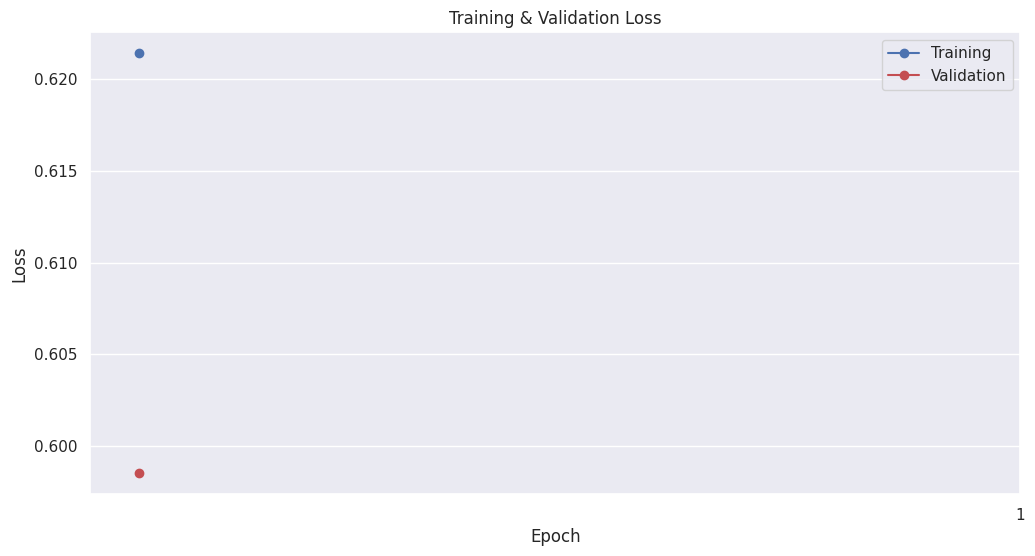

In [6]:
from utils import write_EMO_prediction, plot_loss_curve, compute_EMO_metrics, write_dict_to_json

predictions = encoded2string(predictions, mlb) # TODO: se predice tutti 0 --> Neutral
write_EMO_prediction(predictions, "predictions_EMO.tsv")
plot_loss_curve(training_stats["Training Loss"], training_stats["Validation Loss"], "loss_curve.png")
#scores = compute_EMO_metrics(...)
#write_dict_to_json(scores, "scores.json")

In [14]:
# al trainer si possono passar modelli customized?
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert

# LOSS CURVE
# trainer.state.log_history

# ---- GRID SEARCH ----
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb
# https://huggingface.co/docs/transformers/hpo_train

from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback, EarlyStoppingCallback
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import datasets

# --- TODO: come farlo meglio? ---
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

train_text = list(map(str, train_df['essay']))
train_dict = {'labels': y_train[:20].tolist(), 'text': train_text}
train_dataset = datasets.Dataset.from_dict(train_dict)
tokenized_train = train_dataset.map(preprocess_function, batched=True)

val_text = list(map(str, val_df['essay']))
val_dict = {'labels': y_val[:10].tolist(), 'text': val_text}
val_dataset = datasets.Dataset.from_dict(val_dict)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

dev_text = list(map(str, dev_df['essay']))
dev_dict = {'labels': y_dev[:10].tolist(), 'text': dev_text}
dev_dataset = datasets.Dataset.from_dict(dev_dict)
tokenized_dev = dev_dataset.map(preprocess_function, batched=True)
# --------------------------------

train_arguments = TrainingArguments(
    output_dir="./",
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch", # saves a checkpoint at the end of each epoch
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    load_best_model_at_end=True,
    seed=RANDOM_STATE
) # optim and many others

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("log.jsonl"))

trainer.train()
# results = trainer.evaluate()     # just gets evaluation metrics
results = trainer.predict(tokenized_dev) # also gives you predictions

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 99>:99                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2759 in training_step            │
│                                                                                                  │
│   2756 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2757 │   │                                                                                     │
│   2758 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2759 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2760 │   │                                                                                     │
│   2761 │   │   if self.args.n_gpu > 1:                                                           │
│   2762 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2784 in compute_loss             │
│                                                                                                  │
│   2781 │   │   │   labels = inputs.pop("labels")                                                 │
│   2782 │   │   else:                                                                             │
│   2783 │   │   │   labels = None                                                                 │
│ ❱ 2784 │   │   outputs = model(**inputs)                                                         │
│   2785 │   │   # Save past state if it exists              